In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Layer,
                                     Input,
                                     Dense,
                                     LayerNormalization,
                                     Dropout,
                                     Embedding,
                                     GlobalAveragePooling1D,
                                     MultiHeadAttention)
from sklearn.metrics import classification_report

from material.data import *


class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        """

                |
        +--------------------+
        |   multi-head-att  |
        +-------------------+
                |
        +------------------------+
        |   dropout & layernorm  |
        +------------------------+
                |
        +--------------------+
        |   fully connected  |
        +-------------------+
                |
        +------------------------+
        |   dropout & layernorm  |
        +------------------------+
                |

        """

        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        ffn_output = self.layernorm2(out1 + ffn_output)
        return ffn_output


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)  # farmore easier version of position embeding than the paper
        x = self.token_emb(x)
        return x + positions

In [2]:
x_train, y_train, x_test, y_test, vocab_size, maxlen = imdb_data()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/congyu/.virtualenvs/congyuml/lib/python3.6/site-packages/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/congyu/.virtualenvs/congyuml/lib/python3.6/site-packages/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

(25000, 200)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
(25000, 200)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [5]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

# build the model
inputs = Input(shape=(maxlen,))
x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(2, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 32)           646400    
_________________________________________________________________
transformer_block_1 (Transfo (None, 200, 32)           10656     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0   

In [6]:
# train model
history = model.fit(
    x_train, y_train, batch_size=32, epochs=3, validation_data=(x_test, y_test)
)

Epoch 1/3
782/782 [==============================] - 63s 80ms/step - loss: 0.3882 - accuracy: 0.8134 - val_loss: 0.2854 - val_accuracy: 0.8768
Epoch 2/3
782/782 [==============================] - 61s 78ms/step - loss: 0.1980 - accuracy: 0.9227 - val_loss: 0.3130 - val_accuracy: 0.8720
Epoch 3/3
782/782 [==============================] - 62s 79ms/step - loss: 0.1249 - accuracy: 0.9561 - val_loss: 0.3992 - val_accuracy: 0.8620


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


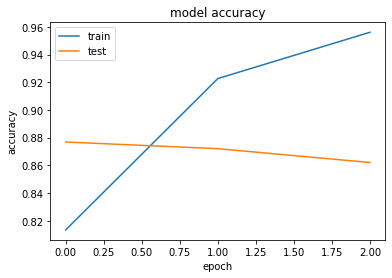

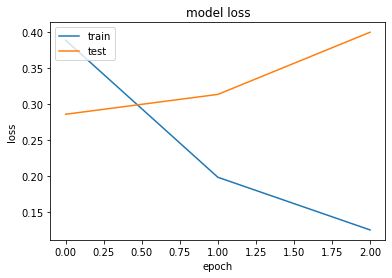

In [7]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
y_pred = model.predict(x_test, verbose=True)
y_pred = np.argmax(y_pred, axis=-1)
y_test = np.argmax(y_test, axis=-1)
print(classification_report(y_test, y_pred))

782/782 [==============================] - 20s 25ms/step


'              precision    recall  f1-score   support\n\n           0       0.89      0.83      0.86     12500\n           1       0.84      0.89      0.87     12500\n\n    accuracy                           0.86     25000\n   macro avg       0.86      0.86      0.86     25000\nweighted avg       0.86      0.86      0.86     25000\n'